In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

device = torch.device(device='cuda' if torch.cuda.is_available() else 'cpu')    

In [2]:
# 加载 MNIST 数据集
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor())

In [14]:
# 超参数设置
input_size = 784  # MNIST 图像大小为 28x28，展平后为 784
num_classes = 10  # 类别数
num_epochs = 50
batch_size = 20000
momentum=0.9
learning_rate = 5e-3

class Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000, bias=True)
        self.fc2 = nn.Linear(1000, 1000, bias=True)
        self.fc3 = nn.Linear(1000, num_classes, bias=True)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Model(input_size, num_classes).to(device)

def reset_parameters(m):
    if isinstance(m, Model):
        for layer in m.children():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)

In [15]:
# 数据加载器
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()

optimizers = {
    'SGDNesterov': torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True),
    'Adam': torch.optim.Adam(model.parameters(), lr=learning_rate),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=learning_rate),
    'AdaDelta': torch.optim.Adadelta(model.parameters(), lr=learning_rate),
    'RMSProp': torch.optim.RMSprop(model.parameters(), lr=learning_rate)
}

training_losses = {name: [] for name in optimizers.keys()}
for name, optimizer in optimizers.items():
    # 训练模型
    print(f"\nTraining with {name} optimizer")
    model.apply(reset_parameters)
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            training_losses[name].append(loss.item())
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Training with SGDNesterov optimizer
Epoch [1/50], Loss: 2.3115
Epoch [2/50], Loss: 2.2554
Epoch [3/50], Loss: 2.1821
Epoch [4/50], Loss: 2.0991
Epoch [5/50], Loss: 2.0122
Epoch [6/50], Loss: 1.9231
Epoch [7/50], Loss: 1.8297
Epoch [8/50], Loss: 1.7359
Epoch [9/50], Loss: 1.6402
Epoch [10/50], Loss: 1.5441
Epoch [11/50], Loss: 1.4507
Epoch [12/50], Loss: 1.3566
Epoch [13/50], Loss: 1.2650
Epoch [14/50], Loss: 1.1833
Epoch [15/50], Loss: 1.1133
Epoch [16/50], Loss: 1.0404
Epoch [17/50], Loss: 0.9720
Epoch [18/50], Loss: 0.9156
Epoch [19/50], Loss: 0.8666
Epoch [20/50], Loss: 0.8189
Epoch [21/50], Loss: 0.7810
Epoch [22/50], Loss: 0.7538
Epoch [23/50], Loss: 0.7102
Epoch [24/50], Loss: 0.6860
Epoch [25/50], Loss: 0.6720
Epoch [26/50], Loss: 0.6439
Epoch [27/50], Loss: 0.6196
Epoch [28/50], Loss: 0.6076
Epoch [29/50], Loss: 0.5881
Epoch [30/50], Loss: 0.5794
Epoch [31/50], Loss: 0.5588
Epoch [32/50], Loss: 0.5485
Epoch [33/50], Loss: 0.5396
Epoch [34/50], Loss: 0.5277
Epoch [35/50], Loss:

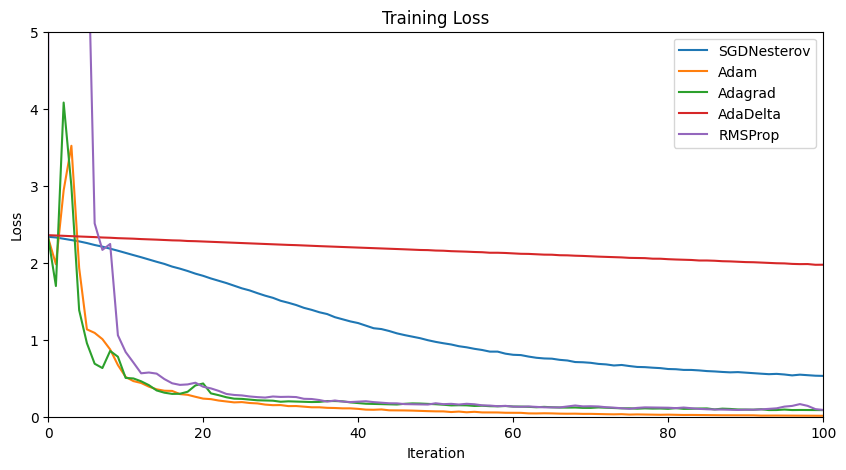

In [18]:
plt.figure(figsize=(10, 5))
for name, losses in training_losses.items():
    plt.plot(losses, label=name)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,5)
plt.xlim(0,100)
plt.show()